In [1]:
from autograd import numpy as np
from fit_zero_boundary import learn_zero_polytope
from fit_convex_polytope import learn_convex_polytope, generate_transitions_for_state, sample_boundary_points
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import pickle

# cvxpy for solving convex optimization problems
import cvxpy as cp

from simulator import sim_NxM, Simulator
import matplotlib.pyplot as plt
%matplotlib inline

## A Polytope 
A polytope is formed by specifying a set of planes (or rather, halfspaces!) that form its facets. 
To build some intuition, here is an example in 2D

In [2]:
def inside_polytope(As, bs, v):
    """
    Returns true if the point v is inside the polytope defined by As and bs. 
    Each row of the matrix As is the normal of a facet, and each corresponding entry in bs is
    the offset of that facet from the origin. 
    """
    return np.all( As@v + bs < 0)

# Define 4 normals of facets (in the diagonal directions, unnormalized)
As = np.array([ [1,1], [-1,-1], [1, -1], [-1, 1] ])
# And their offsets. Notice these are negative, because the normals are assumed to point outwards!
bs = np.array([ -1, -1, -1, -1 ])

resolution = 200
polytope = np.zeros((resolution,resolution))
for i,v1 in enumerate(np.linspace(-2,2,resolution)):
    for j,v2 in enumerate(np.linspace(-2,2,resolution)):
        polytope[i,j] = 1 if inside_polytope(np.array(As),np.array(bs),np.array([v1,v2])) else 0

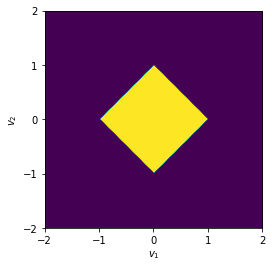

In [3]:
fig, ax = plt.subplots()
ax.imshow(polytope, origin='lower', extent=[-2,2,-2,2], cmap='viridis')
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

## Getting the boundaries

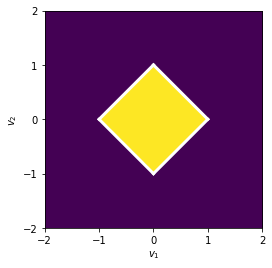

In [4]:
# Stack the two lists, so that we now have a matrix for which each row specifies a facet 
# (i.e. the first entries in the row specify A, the last specify the offset)
eqs=np.hstack([As,bs.reshape(-1,1)])

# Arbitrary point inside polygon (see next cell on how to compute this if unknown instead!)
feasible_point = np.array([0., 0.]) 

fig, ax = plt.subplots()
ax.imshow(polytope, origin='lower', extent=[-2,2,-2,2], cmap='viridis')
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

# Get the corners
hs = HalfspaceIntersection(eqs, feasible_point)
corners = hs.intersections
# Form a convex hull based on the corners
hull = ConvexHull(corners)
# Plot lines between the points forming the hull (they are assumed to come in counterclockwise order)
for simplex in hull.simplices:
    # (Reversing x and y here only for the purposes of plotting; could also diagonally flip the imshow)
    plt.plot(corners[simplex, 1], corners[simplex, 0], '-', c='white', lw=3)

In [5]:
# !! Alternatively, finding a feasible point can be done programmatically using linear programming:
def find_feasible_point(halfspaces):
    norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
    c = np.zeros((halfspaces.shape[1],))
    c[-1] = -1
    A = np.hstack((halfspaces[:, :-1], norm_vector))
    b = - halfspaces[:, -1:]
    res = linprog(c, A_ub=A, b_ub=b, bounds = (None,None))
    return res.x[:-1]

In [6]:
print(find_feasible_point(eqs))

[2.22044605e-16 1.11022302e-16]


## Computing a CSD

Computing a charge stability diagram like we do here makes sense for 2D (i.e. a 2x1 device). 
For larger devices, leading to higher dimensional polytopes, we should be making 2D *slices* through the volume instead. More on that below

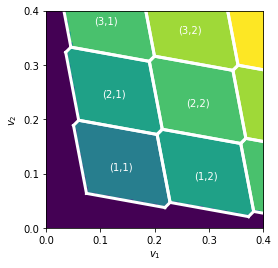

In [7]:
# Set random seed for this example
np.random.seed(0)

delta = 1000
rho = 0.1

# Create a 2x1 device
sim = sim_NxM(1, 2, delta, rho)

# Empty array for storing the charge-stability diagram
resolution = 100
CSD = np.zeros((resolution,resolution))

fig, ax = plt.subplots()

# Loop over all combinations of up to 3 charges on either dot
for n1 in [1,2,3]:
    for n2 in [1,2,3]:
        
        # Set the device in the corresponding charge state
        state = [n1,n2]
        sim.activate_state(state)
        
        polytope=sim.boundaries()
        A=polytope.A
        b=polytope.b
        eqs=np.hstack([A,b.reshape(-1,1)])

        # Get the corners
        feasible_point = find_feasible_point(eqs)
        hs = HalfspaceIntersection(eqs, feasible_point)
        corners = hs.intersections
        # Form a convex hull based on the corners
        hull = ConvexHull(corners)
        # Plot lines between the points forming the hull (they are assumed to come in counterclockwise order)
        for simplex in hull.simplices:
            ax.plot(corners[simplex, 1], corners[simplex, 0], '-', c='white', lw=3)
            
        # Add charge state text 
        if( feasible_point[0] < 0.4 and feasible_point[1] < 0.4 ):
            ax.text(feasible_point[1]-0.025, feasible_point[0]-0.01, "(%d,%d)"%(n1,n2), c="white")
        
        # Raster scan all voltages and see if we're inside the polytope
        for i,v1 in enumerate(np.linspace(0,0.4,resolution)):
            for j,v2 in enumerate(np.linspace(0,0.4,resolution)):
                CSD[i,j] = (1+n1+n2) if sim.inside_state([v1,v2]) else CSD[i,j]
                
ax.imshow(CSD, origin='lower', extent=[0,0.4,0,0.4])
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])

## The model

To find polytopes from measurements, we use the following model function for the polytope.
The parameters of the model are exactly the normals and the offsets of the polytope, and this approach 
allows us to *learn* those using maximum likelihood updates. Notice that the normalization of the normal 
matrices provides a way to sharpen the polytope, and that the offsets can be used to remove unwanted facets.

$$h(v) = \log \sum_{k=1}^M \exp(A_k v+b_k)$$

In [8]:
def logsumexp(xs):
    xmax = np.max(xs.reshape(-1,1), axis=0)
    expxs = np.exp(xs - xmax.reshape(-1,1))
    return np.log(np.sum(expxs,axis=1)) + xmax

def evaluate_model(As, bs, v):
    # Instead of just doing np.log( np.sum( np.exp(As @ v + bs) ) ), we
    # use a numerically more stable version
    return logsumexp(As@v+bs) 

# Define 4 normals of facets (in the diagonal directions, unnormalized)
As = np.array([ [1,1], [-1,-1], [1, -1], [-1, 1], [0,1], [0,-1] ])
# And their offsets. Notice these are negative, because the normals are assumed to point outwards!
bs = np.array([ -1, -1, -1, -1, -0.9, -0.7 ])
eqs=np.hstack([As,bs.reshape(-1,1)])

### Demonstrating the 'sharpness' of the model, and how to (re)move facets

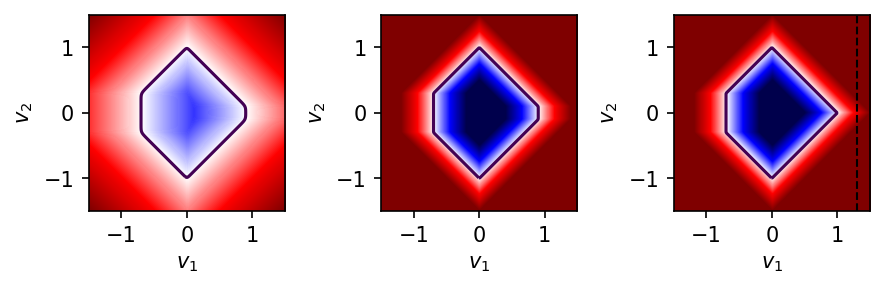

In [9]:
fig, ax = plt.subplots(1,3, dpi=150)

# Define 4 normals of facets (in the diagonal directions, unnormalized)
As = np.array([ [1,1], [-1,-1], [1, -1], [-1, 1], [0,1], [0,-1] ])
# And their offsets. Notice these are negative, because the normals are assumed to point outwards!
bs = np.array([ -1, -1, -1, -1, -0.9, -0.7 ])
eqs=np.hstack([As,bs.reshape(-1,1)])
# Voltage boundaries
vi = -1.5
vf = 1.5
extent=[vi,vf,vi,vf]

# First panel
resolution = 200
polytope = np.zeros((resolution,resolution))
for i,v1 in enumerate(np.linspace(vi,vf,resolution)):
    for j,v2 in enumerate(np.linspace(vi,vf,resolution)):
        polytope[i,j] = evaluate_model(50*As, 50*bs, np.array([v1,v2]))
        
ax[0].imshow(polytope, origin='lower', extent=extent, cmap='seismic', vmin=-100, vmax=100, interpolation='bilinear')
ax[0].contour(polytope, levels=[0.0], extent=extent)
ax[0].set_xlabel("$v_1$")
ax[0].set_ylabel("$v_2$")
ax[0].set_xticks([-1, 0, 1])
ax[0].set_yticks([-1, 0, 1])

# Second panel
resolution = 200
polytope = np.zeros((resolution,resolution))
for i,v1 in enumerate(np.linspace(vi,vf,resolution)):
    for j,v2 in enumerate(np.linspace(vi,vf,resolution)):
        polytope[i,j] = evaluate_model(200*As, 200*bs, np.array([v1,v2]))
        
ax[1].imshow(polytope, origin='lower', extent=extent, cmap='seismic', vmin=-100, vmax=100, interpolation='bilinear')
ax[1].contour(polytope, levels=[0.0], extent=extent)
ax[1].set_xlabel("$v_1$")
ax[1].set_ylabel("$v_2$")
ax[1].set_xticks([-1, 0, 1])
ax[1].set_yticks([-1, 0, 1])
    
# Third panel
# Define 4 normals of facets (in the diagonal directions, unnormalized)
As = np.array([ [1,1], [-1,-1], [1, -1], [-1, 1], [0,1], [0,-1] ])
# And their offsets. Notice these are negative, because the normals are assumed to point outwards!
bs = np.array([ -1, -1, -1, -1, -1.3, -0.7 ])
eqs=np.hstack([As,bs.reshape(-1,1)])

resolution = 200
polytope = np.zeros((resolution,resolution))
for i,v1 in enumerate(np.linspace(vi,vf,resolution)):
    for j,v2 in enumerate(np.linspace(vi,vf,resolution)):
        polytope[i,j] = evaluate_model(300*As, 300*bs, np.array([v1,v2]))
        
ax[2].imshow(polytope, origin='lower', extent=extent, cmap='seismic', vmin=-150, vmax=150, interpolation='bilinear')
ax[2].contour(polytope, levels=[0.0], extent=extent)
ax[2].set_xlabel("$v_1$")
ax[2].set_ylabel("$v_2$")
ax[2].set_xticks([-1, 0, 1])
ax[2].set_yticks([-1, 0, 1])

# For all of the above, we could also have used the same ConvexHull as before, like so:
# hs = HalfspaceIntersection(eqs, np.array([0.,0.]))
# corners = hs.intersections
# # Form a convex hull based on the corners
# hull = ConvexHull(corners)
# # Plot lines between the points forming the hull (they are assumed to come in counterclockwise order)
# for simplex in hull.simplices:
#     ax[2].plot(corners[simplex, 1], corners[simplex, 0], '-', c='k', lw=1) 
    
ax[2].plot( [1.3, 1.3], [vi, vf], '--', lw=1, c='k')
fig.tight_layout()

# Example

### Performing an electron exchange

In [10]:
# Initialize a 3x3 device without reservoirs
delta = 1.0/1000
rho = 0.1

n_rows = 2
n_cols = 2
has_reservoir = False
sim = sim_NxM(n_rows, n_cols, delta, rho)

# These 6 target states are the steps in the exchange of two electrons.
# Please see the main text for a clearer picture.
target_states = np.array([[1,0,1,0],[0,1,1,0],[1,1,0,0], [1,0,0,1]], dtype=np.int64)
# Generate from these states all of the transitions we want to look for
Ts = [generate_transitions_for_state(s, max_k=2, max_moves = 1, has_reservoir=has_reservoir) for s in target_states]

# The transitions possible from the first state are now accessible via, e.g.
print(Ts[0])

# Turn on reservoir temporarily, to set the device in the 00..0 state
sim.set_reservoir(True)
zero_state = np.zeros(sim.num_dots, dtype=np.int64)
sim.activate_state(zero_state)

# Compute the ground truth gamma
gammatruth = sim.boundaries(zero_state).A.copy()

# Then set it to what it should actually be
sim.set_reservoir(has_reservoir)

[[-1  0  0  1]
 [-1  0  1  0]
 [-1  1  0  0]
 [ 0  0 -1  1]
 [ 0  1 -1  0]
 [ 1  0 -1  0]]


#### Learn the zero polytope (all QDs empty) 

In [11]:
# Learn the normals and offsets of the zero polytope, and normalize the normals (last col is the offsets)
gamma, _, _, iter_info = learn_zero_polytope(sim, delta, num_start_samples = 4*sim.num_dots*(sim.num_dots+5))
gamma = gamma/np.linalg.norm(gamma[:,:-1],axis=1).reshape(-1,1)
gamma = gamma[:,:-1]

# A priori, we do not know which transition (row of gamma) belongs to which dot. 
# We're assuming that each dot has one sensor (dot), so we order the rows s.t. for dot i gamma_ij is the largest.
gamma_order = []
for i in range(sim.num_dots):
    jmax = -1
    maxv = -np.infty
    for j in range(sim.num_dots):
        if j in gamma_order: continue
        if np.abs(gamma[j,i]) > maxv:
            maxv = np.abs(gamma[j,i])
            jmax = j
    gamma_order.append(jmax)
gamma=gamma[gamma_order,:]

# Normalize and compare
gammatruth /= np.linalg.norm(gammatruth,axis=1).reshape(-1,1)
gamma /= np.linalg.norm(gamma,axis=1).reshape(-1,1)

# These should all be very close to unity (i.e. the learned gamma matches the true gamma closely)
print(gammatruth/gamma)

[[0.99997176 1.00119115 0.99968607 0.99961591]
 [1.00181539 0.99994274 0.99880825 1.00058641]
 [0.9998279  1.00176564 0.99999291 0.99995874]
 [0.99969384 0.99974184 1.00004844 1.00000757]]


### Now learn all of the other polytopes that are relevant to the target states

In [12]:
# Set a seed for reproducability
np.random.seed(0)

results = []  # For storing learned polytopes
truth = []    # For storing the exact polytopes
for state_idx,target_state in enumerate(target_states):
    # Setup simulation of this state
    sim_step = sim
    gamma_step = gamma
    
    # If we have no reservoir, we need to project away one degree of freedom to have a chance of closed polytopes
    if not has_reservoir:
        # There are N-1 independent directions formed by subtracting one of the principle directions from all other.
        # The Nth principle direction is
        v = np.linalg.inv(gamma_step)@np.ones(sim.num_dots)
        v /= np.linalg.norm(v)
        # For any t with sum(t)=0: t^TAv = 0

        # We remove the vector by defining a householder transformation that would move v->(1,0,...,0)
        # and then we remove the first element (we make use of the fact that the householder transformation is its own inverse)
        h = v.copy()
        h[0] -= 1.0
        h/=np.linalg.norm(h)
        P = np.eye(sim.num_dots) - 2*np.outer(h,h)
        P = P[:,1:]
        
        sim_step = sim_step.slice(P, np.zeros(sim.num_dots))
        sim_step.set_reservoir(False)
        gamma_step = gamma_step@P
        
    # Set device in the target state
    print("\nSetting device in state ", target_state)
    sim_step.activate_state(target_state)
    
    As = sim_step.active_polytope.A
    bs = sim_step.active_polytope.b
    eqs=np.hstack([As,bs.reshape(-1,1)])
    startpoint = find_feasible_point(eqs)
    
    #startpoint, _, _ = sim_step.line_search(polytope.point_inside, np.random.randn(sim_step.num_inputs))
    #startpoint = 0.95*startpoint + 0.05 * polytope.point_inside

    # Learn the polytope (set verbose = 2 for more output, such as the convergence of the max likelihood)
    A, b, x_m, x_p, found, num_searches = learn_convex_polytope(sim_step, delta, startpoint, Ts[state_idx].astype(float), gamma_step, max_searches=200, verbose=1)
    
    results.append({
        "state":target_state.copy(),
        "labels":Ts[state_idx].copy(), "A":A.copy(), "b":b.copy(),
        "found":found,
        "searches":num_searches,
        "x_m":x_m, "x_p":x_p
    })
    
    # Also compute the ground truth (for larger devices, this could/should be commented out!)
    print("Computing ground truth for this state")
    sim_step.activate_state(target_state)
    polytope = sim_step.boundaries(target_state)
    print("Point inside the polytope this state belongs to: ", target_state, polytope.point_inside)
    print("Number of transitions from this state: ",polytope.A.shape[0])
    
    _, radii, _ = sample_boundary_points(polytope.A, polytope.b, sim_step.boundsA, sim_step.boundsb)
    truth.append({
        "state":target_state.copy(), "Gamma": sim_step.Cinv@sim_step.C_g,
        "labels":polytope.labels.copy(), "A":polytope.A.copy(), "b":polytope.b.copy(),
        "radius":radii, "projection":np.ones(sim_step.num_dots,dtype=bool),
        "C": sim_step.C.copy(), "C_g": sim_step.C_g.copy(), "offset": sim_step.offset.copy()
    })


Setting device in state  [1 0 1 0]
Number of searches:  32 / 200
Number of searches:  50 / 200
Number of searches:  68 / 200
Number of searches:  83 / 200
Number of searches:  98 / 200
Number of searches:  113 / 200
Number of searches:  125 / 200
Number of searches:  128 / 200
Number of searches:  131 / 200
Number of searches:  134 / 200
Number of searches:  137 / 200
Number of searches:  140 / 200
Number of searches:  143 / 200
Number of searches:  146 / 200
Number of searches:  149 / 200
Number of searches:  152 / 200
Number of searches:  155 / 200
Number of searches:  158 / 200
Number of searches:  161 / 200
Number of searches:  164 / 200
Number of searches:  167 / 200
Number of searches:  170 / 200
Number of searches:  173 / 200
Number of searches:  176 / 200
Number of searches:  179 / 200
Number of searches:  182 / 200
Number of searches:  185 / 200
Number of searches:  188 / 200
Number of searches:  191 / 200
Number of searches:  194 / 200
Number of searches:  197 / 200
Number o

### See how well the algorithm did

In [13]:
virt_coords = gammatruth @ np.linalg.pinv(gamma)
virt_coords /= np.linalg.norm(virt_coords,axis=1).reshape(-1,1)
err_virt = np.arccos(np.diag(virt_coords))
err_gamma = np.arccos(np.diag(gammatruth@gamma.T))

gamma_searches = iter_info[-1][0]
print("It took %d line searches to learn the zero-polytope"%(gamma_searches))
print("Error on the virtual gates: ", err_virt)
print("Error on gamma: ", err_gamma)

# Evaluate success
dim_base = n_rows * n_cols
gamma_matches = np.sum(iter_info[-1][1] >= dim_base+5 )
gamma_success = (gamma_matches == dim_base)
print("We", "_did_" if gamma_success else "_did not_", "learn the zero-polytope succesfully")

It took 148 line searches to learn the zero-polytope
Error on the virtual gates:  [2.49980957e-04 3.94854641e-04 1.85858992e-04 4.93617063e-05]
Error on gamma:  [2.15938634e-04 3.18454844e-04 1.55804747e-04 4.82276997e-05]
We _did_ learn the zero-polytope succesfully


In [15]:
results_virtual = []
results_poly = []

# Sub smaller because no reservoir?
dim_sub = n_rows * n_cols - 1

# Now we'll compare each polytope from the learning algorithm to the ground truth polytopes
for ind_p, p_truth, p_res in zip(range(len(truth)), truth, results):
    
    # Load polytope equations and normalize
    A_truth = p_truth['A']
    A_truth /= np.linalg.norm(A_truth,axis=1).reshape(-1,1)
    
    A_res = p_res['A']
    A_res /= np.linalg.norm(A_res,axis=1).reshape(-1,1)+1.e-5
    
    b_truth = p_truth['b']
    b_truth /= np.linalg.norm(A_truth,axis=1)
    
    b_res  = p_res['b']    
    b_res /= np.linalg.norm(A_res,axis=1)+1.e-5
    
    # Extract the true max radius and true labels (= transitions)
    radius_truth = p_truth['radius']
    labels_truth = p_truth['labels']
    
    # And also the transitions we wanted to look for, as well as whether we found them
    T = p_res['labels']
    found_res = p_res['found']
    
    print("For polygon %d, we found: "%ind_p, found_res)
    print(A_res[found_res])
    print(b_res[found_res])
    
    # Obtain geometry information of learned polytope
    boundsA = -np.eye(dim_sub)
    boundsb = -2*np.ones(dim_sub)
    radius_res = np.zeros(A_res.shape[0])
    mid_res = np.zeros((A_res.shape[0],dim_sub))

    # Sample points on the boundaries of the found polytopes
    _, radius_res[found_res], mid_res[found_res] = sample_boundary_points(A_res[found_res], b_res[found_res], boundsA, boundsb)
    
    # Use them to find a point inside
    point_inside = np.mean(mid_res[found_res],axis=0)
    found_res = (radius_res > 2.0/delta)

    # Statistics
    num_false_pos = 0
    num_interesting = 0
    num_found = 0
    err_angle = []
    err_b = []
    radius_interesting = []
    found_interesting = []
    workable_interesting = []
    label_interesting = []

    # Enumerate all facets we were looking for
    for pos_res, t in enumerate(T):
        # See if this transition (the row t of T) is anywhere in the true labels
        # (by checking if there is one where the diff sums to zero)
        diff = np.sum(np.abs(labels_truth - t.reshape(1,-1)),axis=1)
        if np.all(diff) > 1.e-3:
            # Facet does not exist, so check if we managed to find it. 
            # If so (i.e. found_res for this index is true), it is a false positive
            num_false_pos += found_res[pos_res]
            continue

        # If we get here, we can now find the index for this transition in the ground truth
        pos_truth = np.where(diff < 1.e-3)[0][0]

        # Check if the facet is large enough to be interesting:
        if radius_truth[pos_truth] < 2.0/delta: #selection criterion
            continue

        # At this point, the facet exists AND is large enough
        num_interesting += 1
        label_interesting.append(t)
        radius_interesting.append(radius_truth[pos_truth])
        found_interesting.append(found_res[pos_res])
        num_found += found_res[pos_res]
        
        # The question remains whether it is actually addressable. Let's assume not for now
        workable_interesting.append(False)

        # No need to continue if we have not found it
        if not found_res[pos_res]:
            continue

        # Measure errors in parameters
        err_angle.append(np.arccos(A_truth[pos_truth]@A_res[pos_res]))
        err_b.append(np.abs(b_truth[pos_truth]-b_res[pos_res]))

        # To check whether the transition is workable, we construct a ray from the 
        # inside of the polytope to the boundary
        direction = mid_res[pos_res]-point_inside
        direction /= np.linalg.norm(direction)

        # TODO
        A_line = A_truth @ direction
        positive = np.where(A_line > 0)[0]
        b_line = b_truth + A_truth @ point_inside
        index = np.argmin(-b_line[positive]/A_line[positive])
        
        if positive[index] == pos_truth:
            workable_interesting[-1] = True
        else:
            print("found, but non-workable:", t)

    # See how many interesting polytopes we've found
    if num_interesting == 0:
        print("No interesting transitions were found for polytope %d"%ind_p)
    else:
        print("For polytope %d, we found %d transitions out of which %d are interesting and %d don't really exist"%(ind_p, num_found, num_interesting, num_false_pos))
        
        radius_interesting=np.array(radius_interesting)
        found_interesting=np.array(found_interesting,dtype=bool)
        workable_interesting = np.array(workable_interesting, dtype=bool)

        results_poly.append({
            "num_found":num_found, "num_interesting":num_interesting, "num_workable":np.sum(workable_interesting),
            "labels": label_interesting, "radius":radius_interesting, "found":found_interesting, "workable": workable_interesting,
            "err_angle":err_angle,
            "err_b":err_b,
            "false_pos": num_false_pos,
            "searches":p_res["searches"]
        })

For polygon 0, we found:  [ True False  True  True  True  True]
[[-0.71938538 -0.69380147 -0.03322957]
 [-0.03033552 -0.76348228 -0.64510042]
 [-0.04382551 -0.8064471   0.58966295]
 [ 0.69018351 -0.72320691 -0.02446388]
 [ 0.77922469 -0.01130593  0.62662673]]
[   99.56023254   105.75134203   131.53778341    12.79811549
 -2277.58278477]


TypeError: 'NoneType' object is not subscriptable

### Evaluate

Text(0.5, 0, 'Deviation (Degrees)')

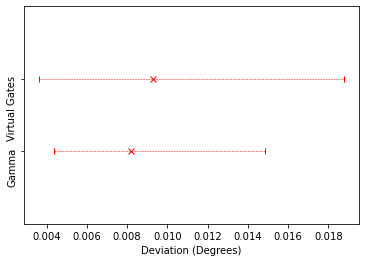

In [65]:
markers = ('x', '+', '.', '1', '*','|')
colors=('r','orange','blue','black', 'grey')
settings= [(1,1,500),(2,1,1000),(3,3,500),(4,3,1000)]

# Angle error
ax = plt.subplot()

qs = results_virtual["error_A0"]*180/np.pi
y=1
ax.plot(qs[[1,3]],(y,y), 'r'+markers[-1]+'--', label=label, c=colors[0],linewidth=0.5)
ax.plot(qs[2],y, markers[0], c=colors[0],linewidth=0.5)

qs = results_virtual["error_virt"]*180/np.pi
y = 2
ax.plot(qs[[1,3]],(y,y), 'r'+markers[-1]+'--', label=label, c=colors[0],linewidth=0.5)
ax.plot(qs[2],y, markers[0], c=colors[0],linewidth=0.5)

ax.set_ylim(0,3)
ax.set_yticks([1,2])
ax.set_yticklabels(["Gamma", "Virtual Gates"], rotation=90)

ax.set_xlabel("Deviation (Degrees)")

Text(0.5, 0, 'Number of Line-searches')

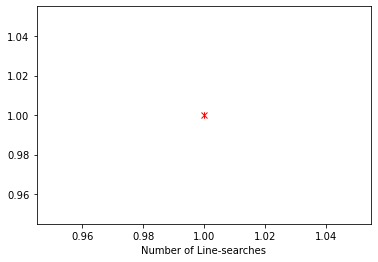

In [66]:
# Angle error
ax = plt.subplot()

qs = results_virtual["searches"]
y=1
ax.plot(qs[[1,3]],(y,y), 'r'+markers[-1]+'--', label=label, c=colors[0],linewidth=0.5)
ax.plot(qs[2],y, markers[0], c=colors[0],linewidth=0.5)
ax.set_xlabel("Number of Line-searches")

#### Fraction of transitions found and workable

In [67]:
num_interesting = 0
num_workable = 0
num_found = 0

for run in results_poly:
    for poly in results_poly[run]:
        num_interesting += poly["num_interesting"]
        num_workable += poly["num_workable"]
        num_found += poly["num_found"]

print("The fraction of transitions found: %.2f"%(num_found/num_interesting))
print("The fraction of found transitions that is workable: %.2f"%(num_workable/num_found))

The fraction of transitions found: 0.98
The fraction of found transitions that is workable: 1.00


#### confidence intervals of radii

No handles with labels found to put in legend.


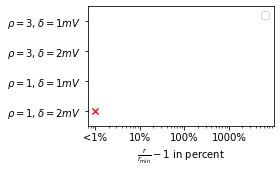

In [68]:
plt.figure(figsize=(4,2.5))

radii=np.zeros(0)
for run in results_poly:
    for poly in results_poly[run]:
        radii = np.append(radii, poly["radius"][~poly["found"]]*delta)

if radii.shape[0] <= 1:
    qs = [2.02,2.02,2.02]
else:
    qs = np.quantile(np.maximum(radii,2.02),[0.5,0.95,1])

y=1
plt.plot(qs[1]/2-1,y, markers[0], label=label, c=colors[0],linewidth=0.5)
plt.plot(qs[0]/2-1,y, markers[0], c=colors[0],linewidth=0.5)


plt.gca().set_yticks([1,2,3,4])
plt.gca().set_yticklabels([r"$\rho=1,\delta=2mV$",r"$\rho=1, \delta=1mV$",r"$\rho=3, \delta=2mV$",r"$\rho=3, \delta=1mV$"])
plt.xscale('log')
plt.gca().set_xticks([0.01,0.1,1,10])
plt.gca().set_xlim(0.007,100)
plt.gca().set_xticklabels(["<1%", "10%", "100%", "1000%"])
plt.gca().set_ylim(0.5,4.5)
plt.xlabel("$\\frac{r}{r_{\min}}-1$ in percent")
plt.legend()
plt.tight_layout()

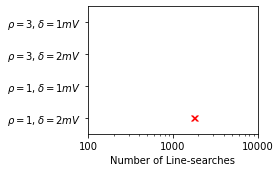

In [69]:
#searches
plt.figure(figsize=(4,2.5))

searches = []
for run in results_poly:
    for poly in results_poly[run]:
        searches.append(poly["searches"])
qs = np.quantile(searches,[0,0.05,0.5,0.95,1])
y=1
label = None
if j == 1:
    label = names_poly[base]
plt.plot(qs[[1,3]],(y,y), 'r'+markers[0]+'--', label=label, c=colors[0],linewidth=0.5)
#plt.plot(qs[2],y, markers[i], c=colors[i],linewidth=0.5)
        
plt.gca().set_yticks([1,2,3,4])
plt.gca().set_yticklabels([r"$\rho=1,\delta=2mV$",r"$\rho=1, \delta=1mV$",r"$\rho=3, \delta=2mV$",r"$\rho=3, \delta=1mV$"])
plt.gca().set_ylim(0.5,4.5)
plt.gca().set_xlim(100,10000)
plt.xscale('log')
plt.gca().set_xticks([100,1000,10000])
plt.gca().set_xticklabels([r"100",r"1000",r"10000"])
#plt.legend()
plt.xlabel("Number of Line-searches")
plt.tight_layout()

##### Runtime

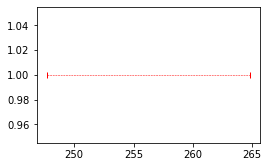

In [70]:
plt.figure(figsize=(4,2.5))
times = []
for run in results_poly:
    for poly in results_poly[run]:
        times.append(poly["time"])
        
qs = np.quantile(times,[0,0.05,0.5,0.95,1])
plt.plot(qs[[1,3]],(1,1), 'r'+markers[i]+'--', label=label, c=colors[0],linewidth=0.5)

#### Check the ladder experiment

In [96]:
t=np.array([-1,1,1,-1,-1,1])
solved = 0
possible = 0
for run in results_poly:
    poly = results_poly[run][0]
    diff = np.sum(np.abs(poly["labels"] - t.reshape(1,-1)),axis=1)
    pos = np.argmin(diff)
    if diff[pos] <1.e-3:
        possible += 1
        solved += poly["workable"][pos]
        
    print("num ladder solved:", solved, possible)

num ladder solved: 1 1
num ladder solved: 2 2


#### Check the shuttle experiment

In [ ]:

#check shuttle
shuttle_ops=np.array([
    [0,0,1,0,-1,0],
    [0,0,-1,1,0,0],
    [-1,0,1,0,0,0],
    [0,0,-1,0,1,0],
    [0,0,1,-1,0,0],
    [1,0,-1,0,0,0]
])
shuttle_ops_prev=-np.array([
    [1,0,-1,0,0,0],
    [0,0,1,0,-1,0],
    [0,0,-1,1,0,0],
    [-1,0,1,0,0,0],
    [0,0,-1,0,1,0],
    [0,0,1,-1,0,0]
])
shuttle_ind_prev=[5,0,1,2,3,4]
for j,rho,delta in settings:
    base="shuttle"
    solved = 0
    possible = 0
    for run in results_poly[base][rho][delta]:
        workable=np.zeros(6)
        num_exist = 0
        for ind,poly in enumerate(results_poly[base][rho][delta][run]):
            t = shuttle_ops[ind]
            t_prev = shuttle_ops_prev[ind]
            
            diff = np.sum(np.abs(poly["labels"] - t.reshape(1,-1)),axis=1)
            pos = np.argmin(diff)
            diff_prev = np.sum(np.abs(poly["labels"] - t_prev.reshape(1,-1)),axis=1)
            pos_prev = np.argmin(diff)
            if diff[pos] <1.e-3:
                num_exist += 1
                workable[ind] += poly["workable"][pos]
            if diff[pos_prev] <1.e-3:
                workable[shuttle_ind_prev[ind]] += poly["workable"][pos_prev]
                
        num_workable = np.sum(workable > 0)
        if num_workable == 6:
            solved += 1
        if num_exist == 6:
            possible += 1
    print("num shuttle solved:", rho, delta, solved, possible)